### Import Dependencies

In [375]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

### Load Data

In [376]:
reviews_full_dataset = pd.read_csv('data/reviews_sentiment.csv')
reviews_full_dataset.head(2)

,album_title,artists,genres,authors,best_new,publish_datetime,review_link,article,score,neg,neu,pos,comp,polarity,subjectivity,flair,flair_pos,flair_neg
0,hypochondriac,brakence,ROCK,H.D. ANGEL,0,2022-12-15T05:01:00,https://pitchfork.com/reviews/albums/brakence-...,brakence’s songs surge with combative angst an...,7.3,0.082,0.819,0.099,0.9583,0.066750,0.463421,-0.994300,0.005700,0.994300
1,Call and Response,Stefan Goldmann,ELECTRONIC,PHILIP SHERBURNE,0,2022-12-15T05:00:00,https://pitchfork.com/reviews/albums/stefan-go...,"In 1947, Bill Putnam discovered the future of ...",6.8,0.047,0.901,0.052,0.6675,0.059063,0.466841,0.999089,0.999089,0.000911


### Train-Test Split

In [377]:
train_set, test_set = train_test_split(reviews_full_dataset, test_size=0.2, random_state=0, shuffle=True)

### Pre-processing & Feature Engineering: Train Set

In [378]:
# Parse genres: creating dummy variables for each genre (an album can have more than one genre)
train_set = train_set.copy()
train_set['genres'].fillna('other', inplace=True)
train_set['genres'] = train_set['genres'].apply(lambda x: x.lower()\
                                                .replace('pop/r&b', 'pop_rnb')\
                                                .replace('folk/country', 'folk_country')
                                                .replace('+1 more', 'one_more'))
                                                # albums w/ 3+ genres
genres = []
for unique_genres in list(train_set['genres'].unique()):
    for genre in unique_genres.split(' / '):
        if genre not in genres:
            genres.append(genre)
try:
    genres.remove('one_more') # Remove this "genre" (n=2)
except ValueError:
    pass
for genre in genres:
    train_set[genre] = train_set['genres'].apply(lambda x: 1 if genre in x else 0)

In [379]:
# Remove outliers 
score_std = np.std(train_set['score'])
score_mean = train_set['score'].mean()
score_high = score_mean + score_std*3
score_low = score_mean - score_std*3

train_set = train_set[(train_set['score']>score_low)&(train_set['score']<score_high)]

In [380]:
# Add author average sentiments as a feature
author_averages = train_set.groupby('authors')[
    ['neg', 'neu', 'pos', 'comp', 'polarity', 
     'subjectivity', 'flair', 'flair_pos', 'flair_neg']].mean().add_prefix('author_').reset_index()

train_set = train_set.merge(
    author_averages,
    on='authors',
    how='left'
)

In [381]:
# Seperate X and y variables
features= [
    'neg', 'neu', 'pos', 'comp', # NLTK VADER scores
    'author_neg', 'author_neu', 'author_pos', 'author_comp',
    'polarity', 'subjectivity', # TextBlob scores
    'author_polarity', 'author_subjectivity', 
    'flair', 'flair_pos', 'flair_neg', # Flair scores
    'author_flair', 'author_flair_pos', 'author_flair_neg',
    'rock', 'electronic', 'rap', 'experimental', 'jazz', # Genres
    'pop_rnb', 'metal', 'folk_country', 'other', 'global'
]

X_train = train_set[features].copy()
y_train = train_set['score'].copy()

### Build & Cross-validate Models

#### Random Forest Regressor

In [382]:
from sklearn.ensemble import RandomForestRegressor

In [383]:
param_grid = { 
    'n_estimators': [250, 500, 750, 1000],
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', 'auto'],
    'bootstrap': [True, False],
    'random_state' : [0]
}
                          
rf_cv = RandomizedSearchCV(
    estimator=RandomForestRegressor(),
    n_iter=20,
    param_distributions=param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error',
    verbose=True,
    random_state=0)

rf_cv.fit(X_train, y_train)

print(f'Best RMSE: {np.sqrt(-rf_cv.best_score_)}')
print(f'Best Hyperparameters: {rf_cv.best_params_}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RMSE: 0.6509594767176896
Best Hyperparameters: {'random_state': 0, 'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 9, 'bootstrap': True}


#### XGBoost Regressor

In [384]:
from xgboost.sklearn import XGBRegressor

In [385]:
param_grid = { 
    'n_estimators': [250, 500, 750, 1000],
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None],
    'learning_rate': [0.03, 0.001, 0.01, 0.1, 0.2, 0.3], 
    'colsample_bytree': [i/10.0 for i in range(1, 3)],
    'gamma': [i/10.0 for i in range(3)],
    'random_state': [0]
}

xgb_cv = RandomizedSearchCV(
    estimator=XGBRegressor(),
    n_iter=20,
    param_distributions=param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error',
    verbose=True,
    random_state=0)

xgb_cv.fit(X_train, y_train)

print(f'Best RMSE: {np.sqrt(-xgb_cv.best_score_)}')
print(f'Best Hyperparameters: {xgb_cv.best_params_}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RMSE: 0.6564412381620857
Best Hyperparameters: {'random_state': 0, 'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.1}


#### CatBoost Regressor

In [386]:
from catboost import CatBoostRegressor

In [387]:
param_grid = { 
    'n_estimators': [250, 500, 750, 1000],
    'depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None],
    'learning_rate': [0.03, 0.001, 0.01, 0.1, 0.2, 0.3], 
    'l2_leaf_reg': [3, 1, 5, 10, 100],
    'border_count': [32, 5, 10, 20, 50, 100, 200],
    'random_state': [0],
    'silent': [True]
}

cat_cv = RandomizedSearchCV(
    estimator=CatBoostRegressor(),
    n_iter=20,
    param_distributions=param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error',
    verbose=True,
    random_state=0)

cat_cv.fit(X_train, y_train)

print(f'Best RMSE: {np.sqrt(-cat_cv.best_score_)}')
print(f'Best Hyperparameters: {cat_cv.best_params_}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RMSE: 0.64037337380257
Best Hyperparameters: {'silent': True, 'random_state': 0, 'n_estimators': 1000, 'learning_rate': 0.03, 'l2_leaf_reg': 5, 'depth': 2, 'border_count': 50}


#### Ensemble Regressor

In [388]:
from sklearn.ensemble import VotingRegressor

In [389]:
param_grid = {
    'weights': [
        (1,1,1), (0,1,1), (1,0,1), (1,1,0),
        (2,1,1), (2,2,1), (1,2,1), (1,2,2), 
        (1,1,2), (1,2,1), (1,1,2),
        (1,0,0), (0,1,0), (0,0,1)
    ]
}

ensemble = VotingRegressor([
    ('rf', rf_cv.best_estimator_), 
    ('xgb', xgb_cv.best_estimator_),
    ('cat', cat_cv.best_estimator_),
])

ensemble_cv = GridSearchCV(
    estimator=ensemble,
    param_grid=param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error',
    verbose=True)

ensemble_cv.fit(X_train, y_train)

print(f'Best RMSE: {np.sqrt(-ensemble_cv.best_score_)}')
print(f'Best Hyperparameters: {ensemble_cv.best_params_}')

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best RMSE: 0.6388685732071409
Best Hyperparameters: {'weights': (1, 1, 2)}


### Pre-processing & Feature Engineering: Test Set

In [391]:
# Parse genres: creating dummy variables for each genre (an album can have more than one genre)
test_set = test_set.copy()
test_set['genres'].fillna('other', inplace=True)
test_set['genres'] = test_set['genres'].apply(lambda x: x.lower()\
                                                .replace('pop/r&b', 'pop_rnb')\
                                                .replace('folk/country', 'folk_country')
                                                .replace('+1 more', 'one_more'))
                                                # albums w/ 3+ genres
genres = []
for unique_genres in list(test_set['genres'].unique()):
    for genre in unique_genres.split(' / '):
        if genre not in genres:
            genres.append(genre)
try:
    genres.remove('one_more') # Remove this "genre" (n=2)
except ValueError:
    pass
for genre in genres:
    test_set[genre] = test_set['genres'].apply(lambda x: 1 if genre in x else 0)

In [392]:
# Remove outliers, using thresholds from train set
test_set = test_set[(test_set['score']>score_low)&(test_set['score']<score_high)]

In [396]:
# Add author average sentiments as a featurel, and use whole data set as to incorporate averages from train data
author_averages = reviews_full_dataset.groupby('authors')[
    ['neg', 'neu', 'pos', 'comp', 'polarity', 
     'subjectivity', 'flair', 'flair_pos', 'flair_neg']].mean().add_prefix('author_').reset_index()

test_set = test_set.merge(
    author_averages,
    on='authors',
    how='left'
)

In [397]:
# Seperate X and y variables
features= [
    'neg', 'neu', 'pos', 'comp', # NLTK VADER scores
    'author_neg', 'author_neu', 'author_pos', 'author_comp',
    'polarity', 'subjectivity', # TextBlob scores
    'author_polarity', 'author_subjectivity', 
    'flair', 'flair_pos', 'flair_neg', # Flair scores
    'author_flair', 'author_flair_pos', 'author_flair_neg',
    'rock', 'electronic', 'rap', 'experimental', 'jazz', # Genres
    'pop_rnb', 'metal', 'folk_country', 'other', 'global'
]

X_test = test_set[features].copy()
y_test = test_set['score'].copy()

### Test Final Model

In [398]:
y_pred = ensemble_cv.best_estimator_.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

0.6751216101421855

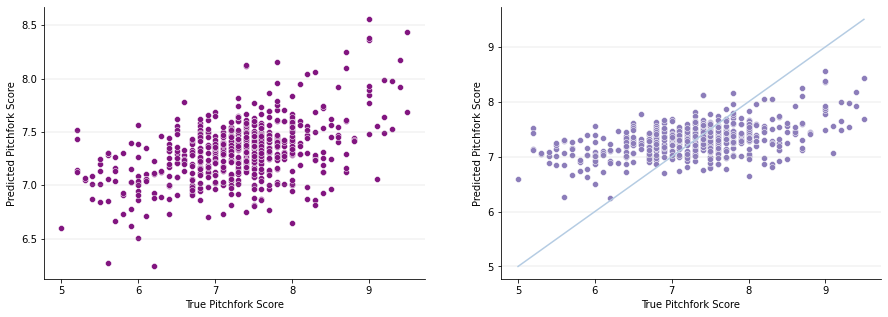

In [406]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
palette = sns.color_palette('BuPu_r')

sns.scatterplot(x=y_test, y=y_pred, ax=axs[0], color=palette[0])
sns.scatterplot(x=y_test, y=y_pred, ax=axs[1], color=palette[2])
axs[1].plot([min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())], 
        [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())], color=palette[4])


axs[0].set_xlabel('True Pitchfork Score')
axs[0].set_ylabel('Predicted Pitchfork Score')

axs[1].set_xlabel('True Pitchfork Score')
axs[1].set_ylabel('Predicted Pitchfork Score')

for ax in axs:
    ax.yaxis.grid(which='major', linewidth=.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.patch.set_alpha(0.0)
    
plt.show()

***Observations***

The test RMSE result was ~0.68, and it does appear as if the predictions and the true values trend positively. 

However, taking a deeper look, the model appears to be optimizing its loss function by tending to predict values near the center of the distribution. As we have noticed before, Pitchfork Review Scores tend to cluster near ~7.5, with little variation. 

That being said, the model tends to predict higher scores when the true value is greater than the central tendency, as well as predict lower scores when the true value is lower than the central tendency.